# Analyzing movie data to determine most profitable genres, studios, and directors

In [ ]:
#Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings
import sqlite3
import zipfile
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [90]:
#Reading in the dataframes

movie_info=pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
tmdb=pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets=pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
movie_gross=pd.read_csv("zippedData/bom.movie_gross.csv.gz")
reviews=pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

In [91]:
#Data dictionary from tmdb website

tmdb_genres={
'Action':        28,
'Adventure':       12,
'Animation':       16,
'Comedy':          35,
'Crime':           80,
'Documentary':     99,
'Drama':           18,
'Family':          10751,
'Fantasy':         14,
'History':         36,
'Horror':          27,
'Music':           10402,
'Mystery':        9648,
'Romance':         10749,
'Science Fiction': 878,
'TV Movie':        10770,
'Thriller':        53,
'War':             10752,
'Western':         37}

In [92]:
tmdb_genres_new=dict(zip(tmdb_genres.values(), tmdb_genres.keys(), ))

#### First step - cleaning the data.

In [93]:
#Cleaning tmdb to remove dupes. Adding a column including title and year to prepare for merge.
tmdb['title_and_year']=tmdb['original_title']+' ' +tmdb['release_date'].apply(lambda x: x[:4])
tmdb=tmdb.drop_duplicates(subset='id', keep='first')
tmdb=tmdb.drop_duplicates(subset='title_and_year', keep='first')

#Creating a matching column in movie_budgets to prepare for merge
movie_budgets['title_and_year']=movie_budgets['movie']+' ' +movie_budgets['release_date'].apply(lambda x: x[-4:])

#Creating numeric columns to represent Budget and Revenue
movie_budgets['revenue']=movie_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)
movie_budgets['budget']=movie_budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)

#Removing duplicates
movie_budgets=movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

In [94]:
#Merging the two dataframes. Inner merge so that we can examine movies for which we have data on both budget and tmdb votes.
tmdb_and_budgets=pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')

In [95]:
#Dropping rows that have $0 as the value for revenue. Further research showed that many of these movies were released directly to streaming services.
tmdb_and_budgets=tmdb_and_budgets.loc[tmdb_and_budgets['revenue']!=0]

#reset index due to dropping rows
tmdb_and_budgets.reset_index(inplace=True)

#removing unnecessary columns
tmdb_and_budgets.drop(['index', 'id_x', 'id_y', 'Unnamed: 0', 'movie', 'original_title', 'title'], axis=1, inplace=True)

#Removing rows with no genre
bad_values=['[]']
tmdb_and_budgets=tmdb_and_budgets.loc[~tmdb_and_budgets['genre_ids'].isin(bad_values)]

#Converting string column to list
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].str.split()

#Creating function to convert genre_id strings into lists
def genre_fixer(g_i):
    if len(g_i)>1:
        cleaned_g_i=[]
        cleaned_g_i.append(int(g_i[0].split('[')[1].split(',')[0]))
        for g in g_i[1:-1]:
            cleaned_g_i.append(int(g.split(',')[0]))
        cleaned_g_i.append(int(g_i[-1].split(']')[0]))
        return cleaned_g_i
    elif len(g_i)==1:
        cleaned_g_i=[]
        cleaned_g_i.append(int(g_i[0].split('[')[1].split(']')[0]))
        return cleaned_g_i

#Creating function to convert genre ids into actual genres    
def genre_mapper(g_i):
    cleaned_g_i=[]
    for g in g_i:
        cleaned_g_i.append(tmdb_genres_new[g])
    return cleaned_g_i

#Applying the functions
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].apply(genre_fixer)
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].apply(genre_mapper)

#resetting index and dropping dupe columns again after removing rows
tmdb_and_budgets.reset_index(inplace=True)
tmdb_and_budgets.drop(['index'], axis=1, inplace=True)

#Adding numeric column to examine ratio of revenue to budget
tmdb_and_budgets['revenue_to_budget']=tmdb_and_budgets['revenue']/tmdb_and_budgets['budget']

### Creating a new dataframe to compare revenue, genres, studio, and ratings.

In [96]:
#Preparing movie gross for merge with tmdb_and_budgets
movie_gross['title_and_year']=movie_gross['title']+' ' +movie_gross['year'].astype(str)

#Merging so that we can compare studios, budgets/revenue, and genre.
studios=pd.merge(tmdb_and_budgets, movie_gross, on='title_and_year')

### What are the most profitable studios overall?

We measure profitability by the ratio of revenue to budget.

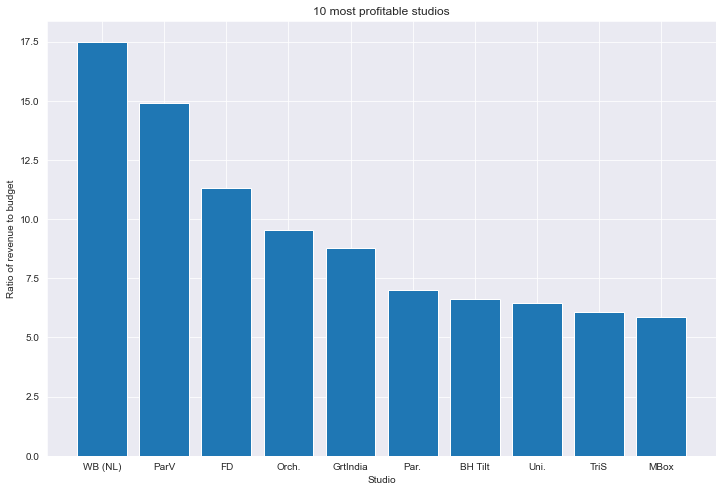

In [97]:
#finding the 10 most profitable studios
profitable_studios=studios.groupby('studio')['revenue_to_budget'].mean().sort_values(ascending=False)[:10]

#displaying the results
fig, ax=plt.subplots(figsize=(12,8))
ax.bar(profitable_studios.index, profitable_studios.values)
ax.set_title('10 most profitable studios');
ax.set_xlabel('Studio')
ax.set_ylabel('Ratio of revenue to budget');

### How about the most profitable genres?

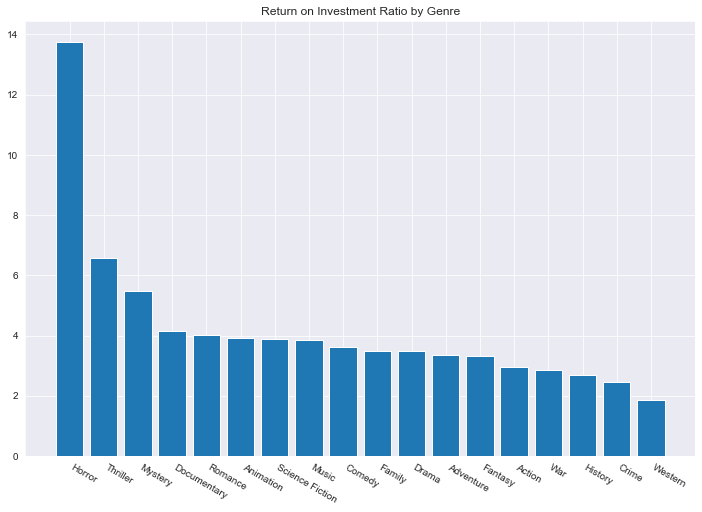

In [98]:
#Creating a dictionary to find the return on investments for each movie in a particular genre
genre_rois={}
for row in studios.index:
    g_ids=studios.iloc[row]['genre_ids']
    rtb=studios.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in genre_rois.keys():
            genre_rois[g]=np.append(genre_rois[g], rtb)
        else:
            genre_rois[g]=np.array([rtb])

#Creating a second dictionary to store just the average return on investments for each genre
genre_rois_average={}
for g in genre_rois.keys():
    genre_rois_average[g]=genre_rois[g].mean()

genre_ids=list(genre_rois_average.keys())
rois=list(genre_rois_average.values())
genres_and_rois=pd.DataFrame(data=rois, index=genre_ids, columns={'Return on Investment'})
genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(genres_and_rois.index, genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre')
ax.set_xticklabels(genres_and_rois.index, rotation=-30, ha='left');

Confirming there is a statistically significant difference in ROI based on genre:

In [105]:
assert(stats.f_oneway(*genre_rois.values())[1]<0.05)

### Our stakeholder is interested in current movies, is there a difference in results?

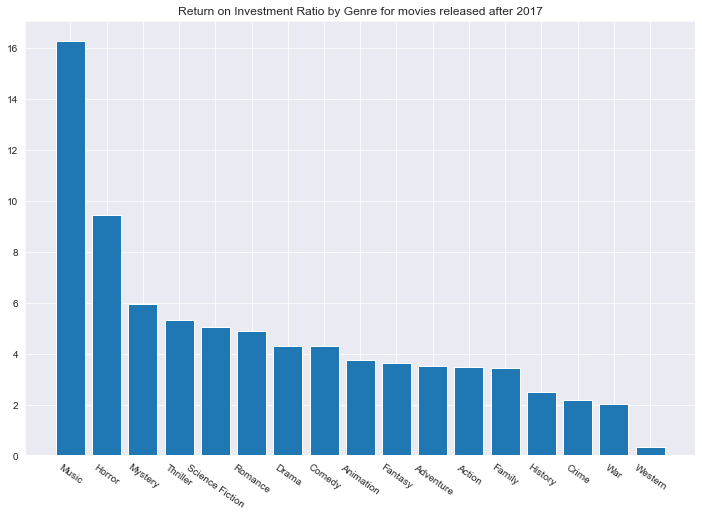

In [100]:
#repeating the same steps as above, but for new movies only

new_movies=studios.loc[studios['year']>2017]
new_movies.reset_index(inplace=True)

new_genre_rois={}
for row in new_movies.index:
    g_ids=new_movies.iloc[row]['genre_ids']
    rtb=new_movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in new_genre_rois.keys():
            new_genre_rois[g]=np.append(new_genre_rois[g], rtb)
        else:
            new_genre_rois[g]=np.array([rtb])

new_genre_rois_average={}
for g in new_genre_rois.keys():
    new_genre_rois_average[g]=new_genre_rois[g].mean()

assert(stats.f_oneway(*new_genre_rois.values())[1]<0.05)

new_movies_genres_and_rois=pd.DataFrame(index=new_genre_rois_average.keys(), data=new_genre_rois_average.values(), columns={'Return on Investment'})
new_movies_genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(new_movies_genres_and_rois.index, new_movies_genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre for movies released after 2017')
ax.set_xticklabels(new_movies_genres_and_rois.index, rotation=-35, ha='center');

We can see that for recent movies, music has become the most profitable genre.

### So what studios should we work with for each genre?

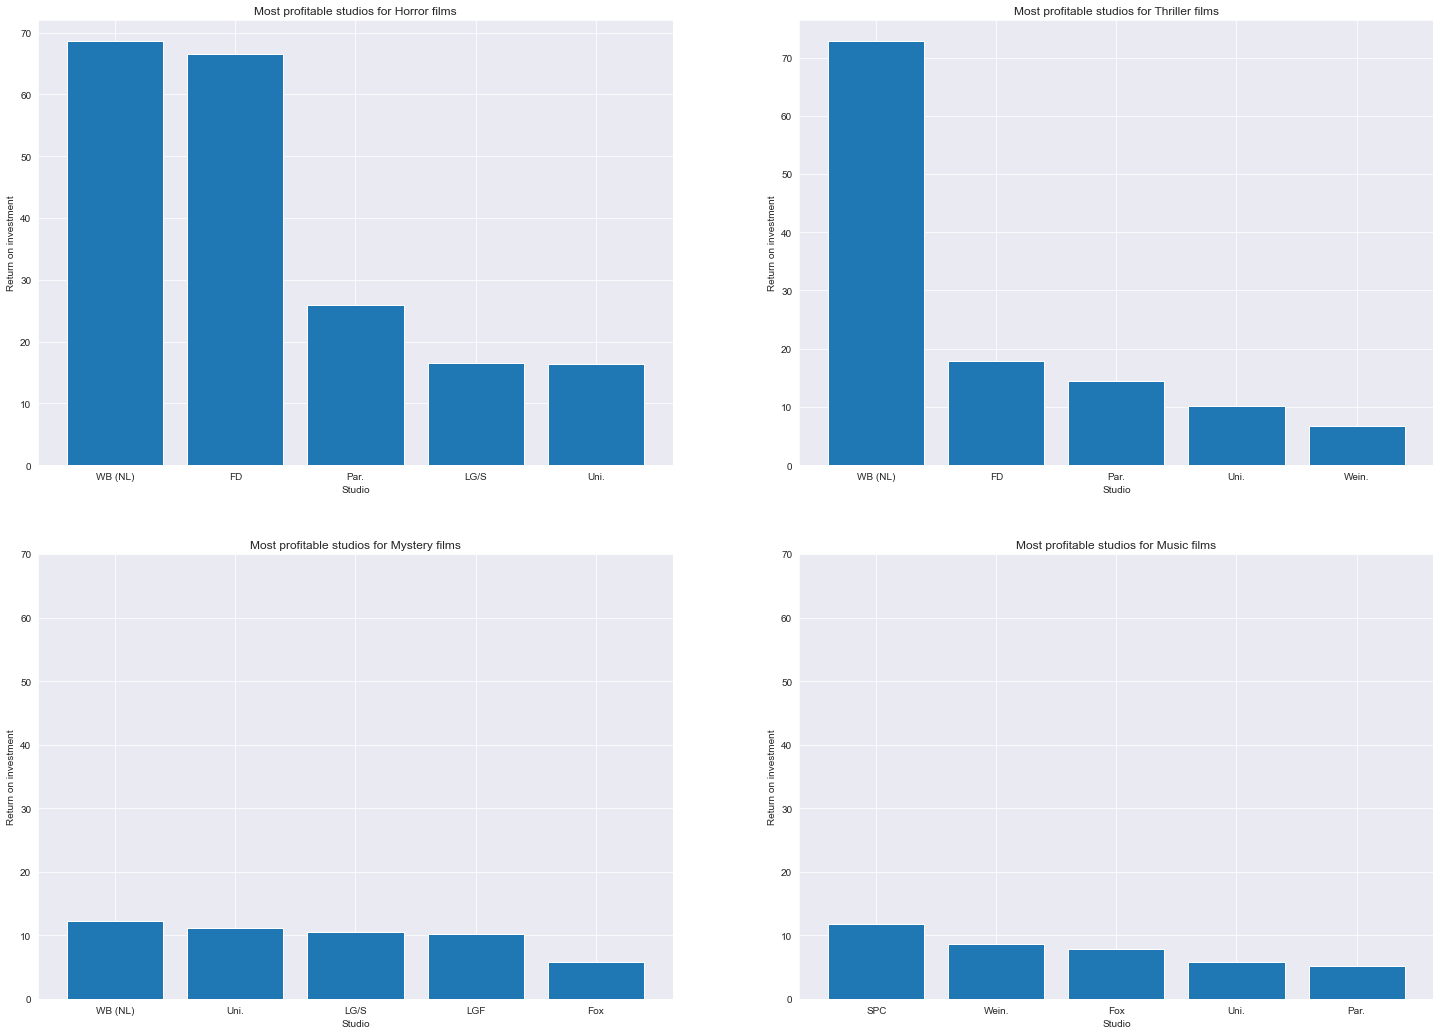

In [101]:
recommended_genres=['Horror', 'Thriller', 'Mystery', 'Music']

#finding the most profitable studio for each genre
studio_revenue_counts={genre:{} for genre in recommended_genres}
for genre in recommended_genres:
    for i in studios.index:
        genres=studios['genre_ids'].iloc[i]
        s=studios['studio'].iloc[i]
        rtb=studios['revenue_to_budget'].iloc[i]
        for g in genres:
            if g in studio_revenue_counts.keys():
                if s in studio_revenue_counts[g].keys():
                    studio_revenue_counts[g][s]=np.append(studio_revenue_counts[g][s], rtb)
                else:
                    studio_revenue_counts[g][s]=np.array([rtb])

#running a test to see if data is statistically significant
def stat_checker(genre_dict):
    return stats.f_oneway(*genre_dict.values())[1]<0.05

for genre in recommended_genres:
    assert(stat_checker(studio_revenue_counts[genre])==True)

#finding the mean of the return on investments for each studio
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(25,18))
for i, genre in enumerate(recommended_genres):
    studio_average_roi={}
    for k in studio_revenue_counts[genre].keys():
        studio_average_roi[k]=np.mean(studio_revenue_counts[genre][k])
    df=pd.DataFrame(index=studio_average_roi.keys(), data=studio_average_roi.values(), columns={'Mean_ROI'}).sort_values(by='Mean_ROI', ascending=False)
    ax[i//2][i%2].bar(df.index[:5], df['Mean_ROI'][:5])
    ax[i//2][i%2].set_title(f'Most profitable studios for {genre} films')
    ax[i//2][i%2].set_xlabel('Studio')
    ax[i//2][i%2].set_ylabel('Return on investment')
    ax[i//2][i%2].set_yticks(np.arange(0, 75, 10))


### Linear regression model to predict revenue based on budget.

In [102]:
#Creating linear regression model comparing budget's impact on revenue.
X=studios['budget']
y=studios['revenue']
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1714.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          4.50e-227
Time:                        11:55:42   Log-Likelihood:                -22476.
No. Observations:                1109   AIC:                         4.496e+04
Df Residuals:                    1107   BIC:                         4.497e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -9.36e+05    6.1e+06     -0.153      0.878   -1.29e+07     1.1e+07
budget         3.2998      0.080     41.397      0.000       3.143       3.456
==============================================================================
Omnibus:                      514.606   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5486.377
Skew:                           1.858   Prob(JB):                         0.00
Kurtosis:                      13.243   Cond. No.                     1.01e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Is using this model to predict revenue better than just looking at the mean?

In [103]:
#Examining the model metrics:
y_hat=results.params[1]*X+results.params[0]
MAE=np.mean(abs(y-y_hat))
MSE=np.mean((y-y_hat)**2)
RMSE=np.sqrt(MSE)

#Compare to baseline model:
MAE_baseline=np.mean(abs(y-y.mean()))
MSE_baseline=np.mean((y-y.mean())**2)
RMSE_baseline=np.sqrt(MSE_baseline)

#Confirm the model is better than the baseline model:
assert(MAE<MAE_baseline)
assert(MSE<MSE_baseline)
assert(RMSE<RMSE_baseline)

Since the model passed our statistical tests, we can say that it is better to use our model to predict revenue based on budget than to just use the mean value for revenue in our dataset.

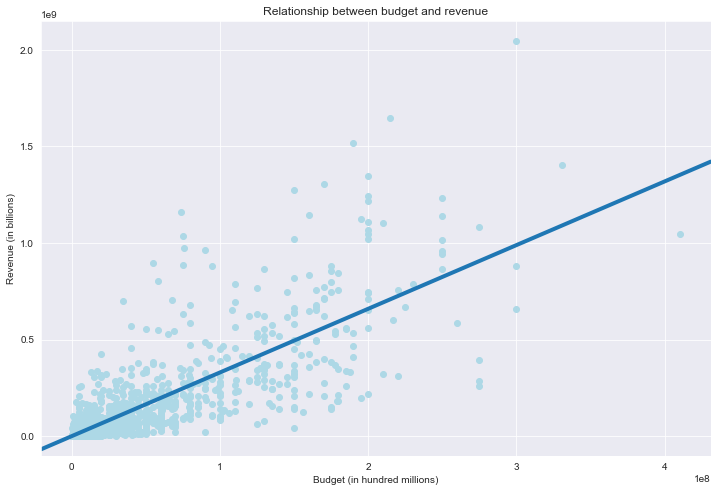

In [104]:
#Plotting linear regression model for budget and revenue.
fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(X, y, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Revenue (in billions)')
ax.set_title('Relationship between budget and revenue')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

For every extra $1 spent in budget, the movie brings in on average $3.30 dollars extra in revenue

## Conclusion

The most profitable genres over the timeline of our dataset are horror, thriller, and mystery. In recent years music has also become very profitable as well. For horror, thriller, and mystery movies we recommend partnering with Warner Brothers. For musicals we recommend working with SPC. Our studio shouldn't be afraid to have a larger budget for movies, as on average for every extra $1 spent in budget a movie brings in $3.30 dollars extra in revenue. Our models have shown that budgeting is a statistically significant predictor for revenue, and that there is statistical significance in the difference in return on investments based on genre.